#### This is taken from pytorch's begginer_source/blitz/cifar10_tutorial.py, with some slight tweeks, and was made into a jupyter notebook with additional notes
link : https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py

----------------------

# A sample Convolutional Neural Network

---------------------
---------------------
#### 1. Download the CIFAR10 dataset

    first we download the dataset needed, here we use the cifar10 image dataset

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# when applied, this will normalize the data from the ranges of (-1) to 1 
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

print('\ntraining data set number of sample images = ',len(trainset))
print('testing data set number of sample images  = ',len(testset))

Files already downloaded and verified
Files already downloaded and verified

training data set number of sample images =  50000
testing data set number of sample images  =  10000


---------------------
#### 2. Partition the Datset into batches

    here we partition the 50,000 training images into 100, making 500 batches and,
    10,000 sample images of test images into 100, making 100 batches
    
    where each batches contains 100 images

In [2]:
batch_size = 100

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

---------------------
##### (optionals) check the shape of our datasets

In [3]:
# here we don't need to flatten every images in our dataset before feeding it to our neural network

for data in trainloader:
    images, labels = data
    print('images dataset shape = ', images.shape)
    print('labels dataset shape = ', labels.shape)
    break

images dataset shape =  torch.Size([100, 3, 32, 32])
labels dataset shape =  torch.Size([100])


---------------------
##### (optionals) Quick peek in the images

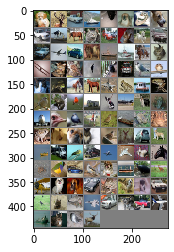

  dog  deer   car  ship   cat   dog  ship   dog   car plane horse   cat   car   cat horse   car   car plane   car   dog  ship  ship horse   cat plane   cat  bird plane   cat truck  bird  bird   cat  frog horse horse plane  frog  ship  frog  bird  frog  bird truck   dog plane   dog  frog plane  bird  bird horse  bird  ship  frog  frog  frog   cat   dog   cat  bird  deer   car   dog  ship truck  bird truck plane plane   cat horse  frog  bird   car  bird   dog  ship  bird  deer plane   dog   dog   car  frog  bird   cat   car  bird  frog   cat plane   car   dog   car plane  ship   cat  bird  deer


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

---------------------
#### 3. Build the Convolution Neural Network

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
                
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        
        return x


net = Net() # CPU

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# net.to(device) # GPU

---------------------
#### (optionals) NOTE : if you are curious on how to get the shapes after pooling or convolution, this is the function

    though since I'm the one who wrote this one, there might be errors in this function

In [6]:
def conv_out_len(N,kernel_len=1, stride=1):
    cnt = 0
    i = 0
    while i < N:
        if i+kernel_len > N:
            break
        cnt += 1
        i += stride
    return cnt

---------------------
#### The shape of the weights of the network

conv1 kernel 1 shape explanation

    1. net.conv1.weight.shape[0] = 6
        this is a user defined numbers of features, or number of kernels,
        defined in the 2nd argument of 'self.conv1 = nn.Conv2d(3, 6, 5)' in '__init__',
        this kernel will be a 3 dimensional matrix/tensor, where the extra dimension is the channels,
        and the remaining will be the 2d image
        
    2. net.conv1.weight.shape[1] = 3
        this is the numbers of channels our 2d kernels will have,
        this should have the same value with the channels of the training and test dataset images
        defined in the 1st argument of 'self.conv1 = nn.Conv2d(3, 6, 5)' in '__init__'
        
    3. net.conv1.weight.shape[2&3] = 5x5
        this is the size of the 2d kernel
        defined in the 3rd/last argument of 'self.conv1 = nn.Conv2d(3, 6, 5)' in '__init__'

$
\begin{matrix}
\text{conv1 2D kernels} & = & 6x3x5x5 \\
\text{conv2 2D kernels} & = & 16x6x5x5 \\
\text{fc1 1D weight} & = & 120x400 \\
\text{fc2 1D weight} & = & 84x120 \\
\text{fc3 1D weight} & = & 10x84 \\
\end{matrix}
$

kernels are just like weights, but instead of a a collection of 1 dimensional vector that is connected to a node
represented by a rectangular matrix like a feed forward network, convolutional layers are more like
a collection of 2 dimensional matrix

-----------------------

#### Feed Forward Output Shapes of Layers

    this is the output shapes of each layers when the input is
    passed into the network using the forward function,
    
    here the forwad-step number 0.) is the input, 100 batches of 32x32 images, with 3 channels rgb
    
$
    \begin{matrix}
    \mathbf{forward-steps} &\mathbf{layer} & \mathbf{kernel/weight-shape}& \mathbf{operation} & \mathbf{input-shape} & \mathbf{output-shape} \\
    0.) & \text{image batch} & n/a & n/a & 100x3x32x32 & 100x3x32x32 \\
    1.) & \text{conv1} & 6x3x5x5 & \text{convolution} & 100x3x32x32 & 100x6x28x28 \\
    2.) & \text{pool} & 2x2 & \text{maxpooling} & 100x6x28x28 & 100x16x14x14 \\
    3.) & \text{conv2} & 16x6x5x5 & \text{convolution} & 100x16x14x14 & 100x16x10x10 \\
    4.) & \text{pool} & 2x2 & \text{maxpooling} & 100x16x10x10 & 100x16x5x5 \\
    5.) & \text{flatten} & n/a & \text{flatten conv2 output} & 100x16x5x5 & 100x400 \\
    6.) & \text{fc1} & 120x400 & \text{matrix multiply} & 100x400 & 100x120 \\
    7.) & \text{fc2} & 84x120 & \text{matrix multiply} & 100x120 & 100x84 \\
    8.) & \text{fc3} & 10x84 & \text{matric multiply} & 100x84 & 100x10 \\
    \end{matrix}
$

maxpooling here has a stride of 2

#### This is what is happening inside the forward() function of out neural network

---------------------
####  4. Choosing our optimizer
    
    you can use any optimizer you want, either the classic SGD(sochastic gradient descent), 
    or the newer ones like AdaGrad, and etc.
    
    but here we will used the most recent optimizer that is considered
    to be one of the fastest optimizer for updating our neural networks' weight called 'Adam',
    so that we will have a faster convergence and use only a small numbers of epoch(training loop)

In [7]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)

---------------------
#### 5. Train the neural network

In [8]:
import time

start = time.time()

EPOCH = 8

for epoch in range(EPOCH):
    for data in trainloader:
        inputs, labels = data # CPU
#         inputs, labels = data[0].to(device), data[1].to(device) # To GPU

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = F.nll_loss(outputs, labels) # loss function use in tandem with log_softmax
        loss.backward()
        optimizer.step()

end = time.time()
            
print('Finished Training, \nTraining took',(end-start),'seconds')

Finished Training, 
Training took 646.096339225769 seconds


---------------------
#### (optionals) Save the trained model

In [9]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

---------------------
#### (optionals)  Load the model back

In [10]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

---------------------
#### (optionals)  Try one item in the test dataset using the model

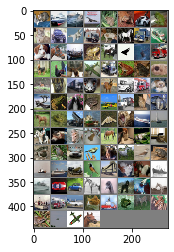

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship plane  ship


In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]for j in range(4)))

---------------------
#### 6. Check the Accuracy of the model from out datasets

In [12]:
start = time.time()

correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        # calculate outputs by running images through the network 
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on training images: %d %%' % (100 * correct / total))
        
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on testing images: %d %%' % (100 * correct / total))

end = time.time()

print('The whole cell took ',(end-start), 'seconds')

Accuracy of the network on training images: 67 %
Accuracy of the network on testing images: 62 %
The whole cell took  86.24760913848877 seconds
